In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs               
import cartopy.feature as cfeature         
import cartopy.util as cutil
import xarray as xr                        
import numpy as np
import pandas as pd
import xesmf as xe
import plotting_module

In [2]:
ozone_dataset = xr.open_dataset("/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.O3.200201-202412.nc")
ps_dataset = xr.open_dataset('/glade/campaign/acom/acom-climate/UTLS/shawnh/archive/FCnudged_f09.mam.mar27.2000_2021.002/atm/proc/tseries/month_1/FCnudged_f09.mam.mar27.2000_2021.002.cam.h0.PS.200201-202412.nc')

In [3]:
ozone = ozone_dataset["O3"]

In [4]:
p0 = ozone_dataset["P0"]
hyai = ozone_dataset["hyai"]
hybi = ozone_dataset["hybi"]
ps = ps_dataset['PS']
lev = ozone_dataset.coords['lev']
num_lev = lev.shape[0]

In [5]:
ps

<xarray.DataArray 'PS' (time: 276, lat: 192, lon: 288)> Size: 61MB
[15261696 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 2kB 2002-02-01 2002-03-01 ... 2025-01-01
Attributes:
    units:         Pa
    long_name:     Surface pressure
    cell_methods:  time: mean

In [6]:
# convert to hPa from Pa
p0 = p0.copy() / 100
ps = ps.copy() / 100

Create climatology

In [7]:
start_date = '2005-02-01'
end_date = '2025-01-01'

# group the 240 month dates based on calendar months for both PS and O3 variables


truncated_ozone = ozone.sel(time=slice(start_date, end_date))
ozone_monthly_mean = truncated_ozone.groupby('time.month').mean('time')
ozone_monthly_mean = ozone_monthly_mean.transpose('lev','month','lat','lon')

truncated_ps = ps.sel(time=slice(start_date, end_date))
ps_monthly_mean = truncated_ps.groupby('time.month').mean('time')
ps_monthly_mean = ps_monthly_mean.transpose('month','lat','lon')

Tropospheric column calculations:

Calculating pressure at hybrid levels
p(k) = a(k) * p0 + b(k) * ps

In [8]:
# threshold value in hPa
threshold = 100

# constants / conversion factor
NAv = 6.0221415e+23                       # molecules in mole
g = 9.81                                  # gravity
MWair = 28.94                             # g/mol
xp_const = (NAv * 10)/(MWair*g)           # scaling factor, pa to hPa and cm to m
DU_CONVERSION = 2.69 * 10**16

In [9]:
# Initialize pressure edge arrays
mod_press_edge_top = xr.zeros_like(ozone_monthly_mean)
mod_press_edge_bottom = xr.zeros_like(ozone_monthly_mean)

In [10]:
# Calculate pressure edge arrays
# Indices start at the top and end at the bottom
for i in range(num_lev):
    mod_press_edge_top[i,:,:,:] = hyai[i]*p0 + hybi[i]*ps_monthly_mean
    mod_press_edge_bottom[i,:,:,:] = hyai[i+1]*p0 + hybi[i+1]*ps_monthly_mean

In [11]:
filtered_300hpa_upper = mod_press_edge_top.where(mod_press_edge_top >= threshold, drop=False)
filtered_300hpa_lower = mod_press_edge_bottom.where(mod_press_edge_bottom >= threshold, drop=False)

In [12]:
filtered_deltap = filtered_300hpa_lower - filtered_300hpa_upper

pres_top_v_300 = mod_press_edge_top - threshold
pres_bottom_v_300 = mod_press_edge_bottom - threshold

In [13]:
filtered_deltap_sliver = pres_bottom_v_300
filtered_deltap_sliver = filtered_deltap_sliver.where(pres_bottom_v_300 >= 0)
filtered_deltap_sliver = filtered_deltap_sliver.where(pres_top_v_300 < 0)

In [14]:
filtered_deltap_sliver = filtered_deltap_sliver.fillna(0)

In [15]:
# sum up both the layer edge and the pressure column to the ground

combined_filtered_deltap = filtered_deltap.copy().fillna(0) + filtered_deltap_sliver
#combined_filtered_deltap

In [16]:
ozone_array = xr.zeros_like(ozone_monthly_mean)
ozone_array = ozone_monthly_mean.where(combined_filtered_deltap > 0)

In [17]:
ozone_array = ozone_array.fillna(0)

In [18]:
ozone_column = xr.dot(combined_filtered_deltap, xp_const*ozone_array, dims='lev')

In [19]:
ozone_full_du_column = ozone_column.copy() / DU_CONVERSION

Regridding and plotting

In [20]:
omi_mls_ds = xr.open_dataarray("/glade/u/home/mvoncyga/SOARS_2025/OMIMLS_100hpa_monthly_mean_2005_2024_full")

omi_mls_ds = omi_mls_ds.rename({'latitude': 'lat', 'longitude': 'lon'})

# shifting lon to be 0-360
omi_mls_ds['lon'] = omi_mls_ds['lon'] % 360
omi_mls_ds = omi_mls_ds.sortby('lon')

In [21]:
regridder = xe.Regridder(ozone_full_du_column, omi_mls_ds, 'bilinear', periodic=True)  
cesm_regridded = regridder(ozone_full_du_column)

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/xesmf/smm.py:131: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


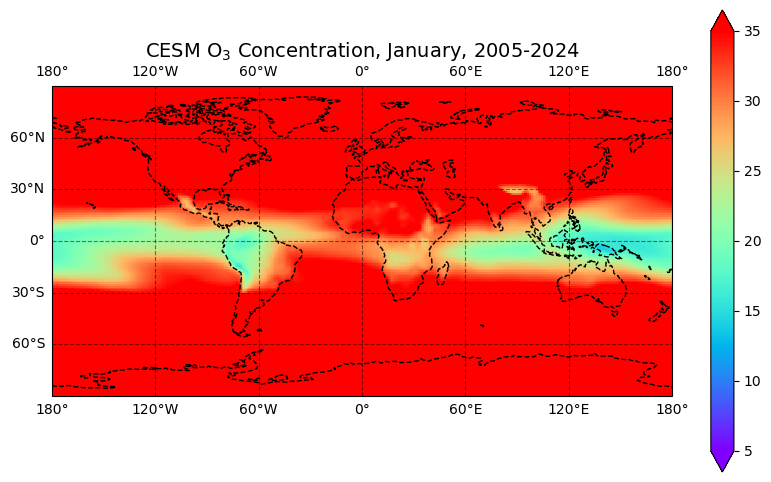

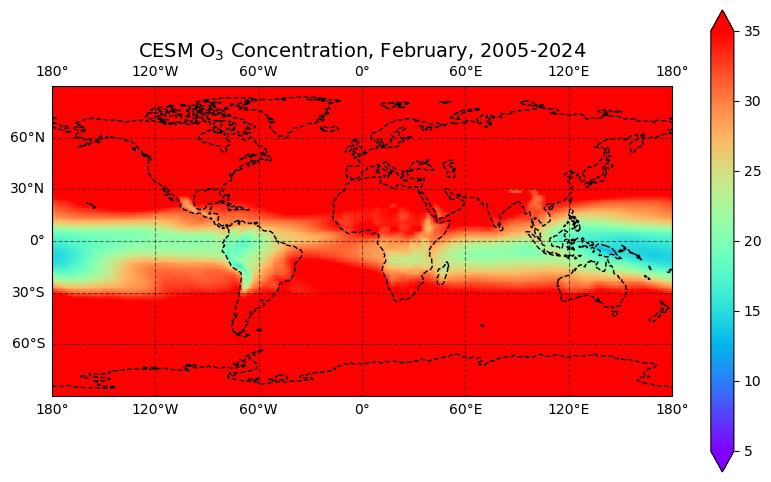

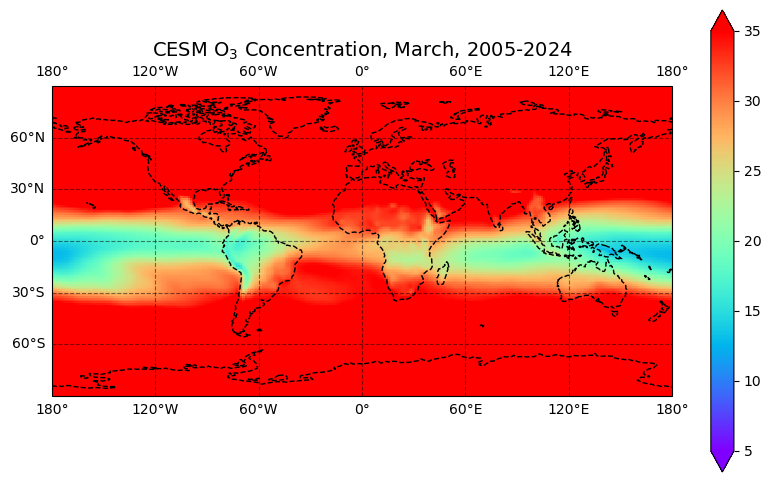

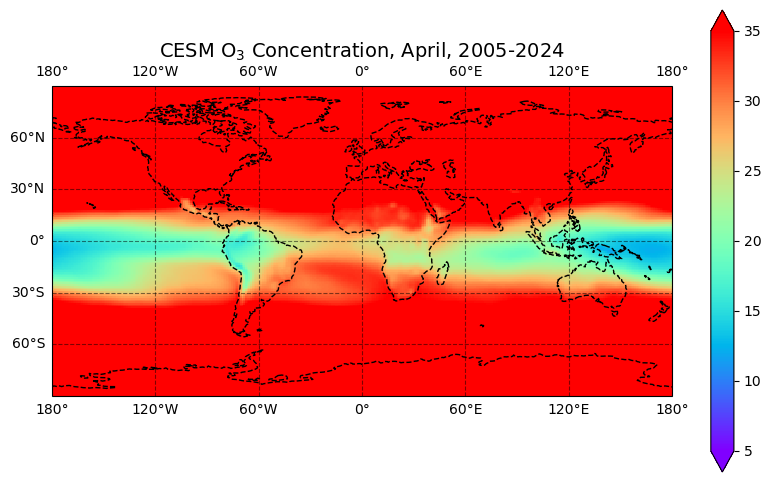

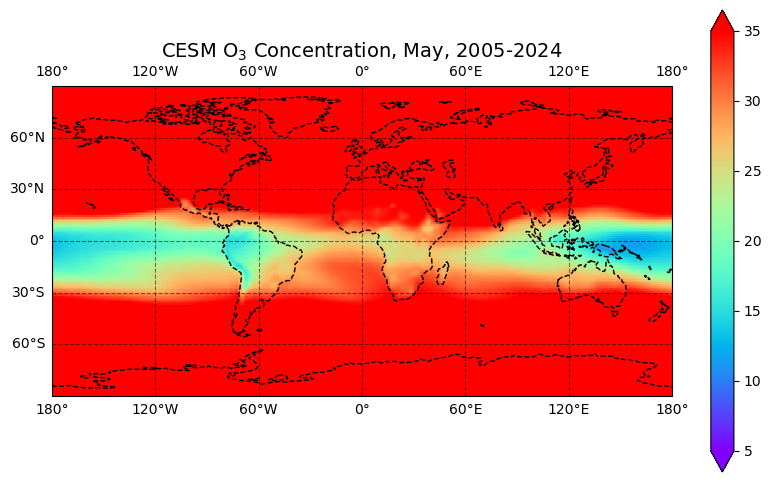

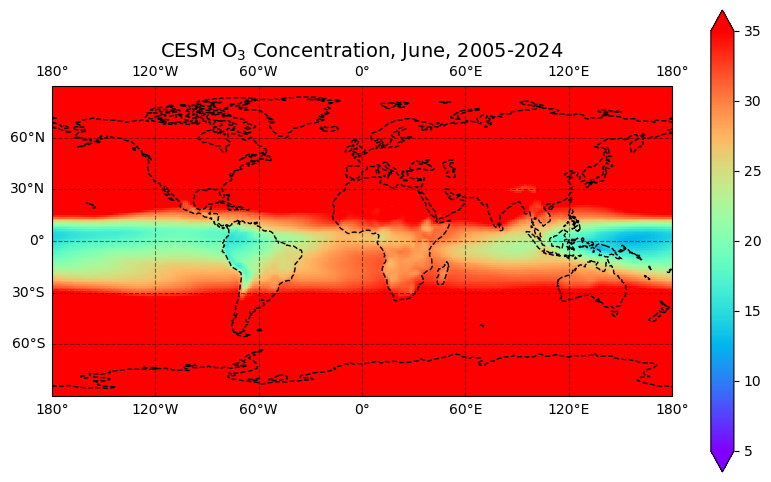

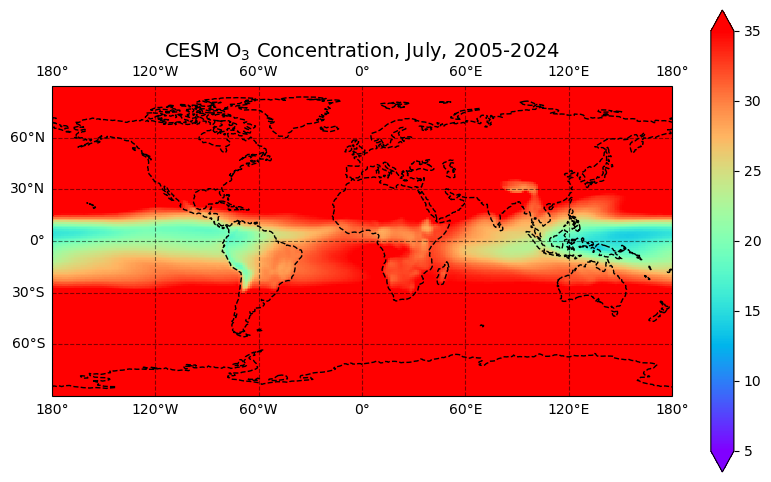

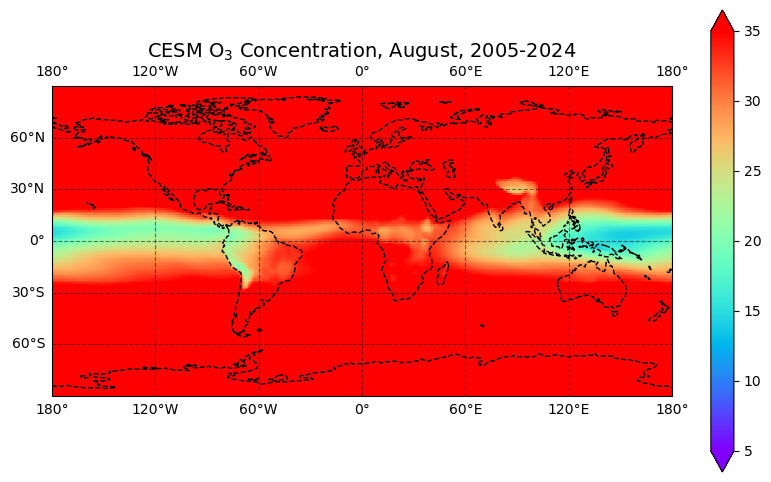

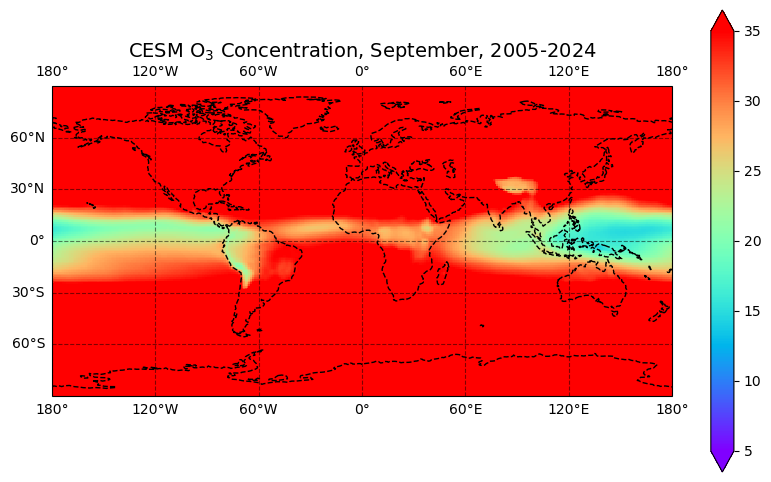

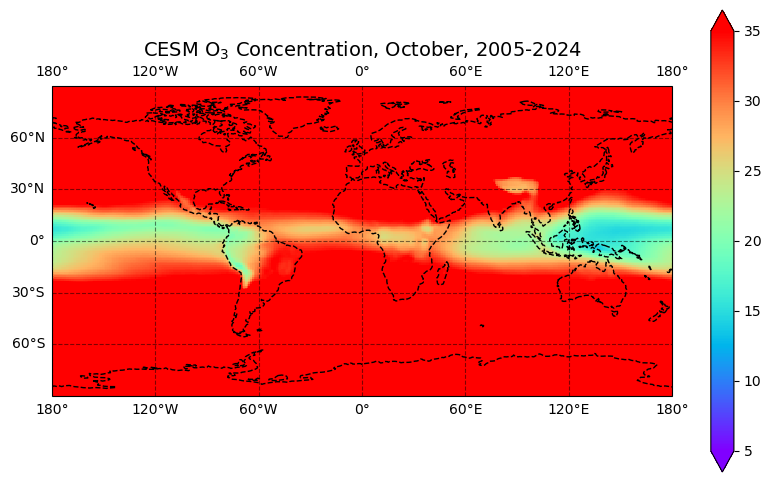

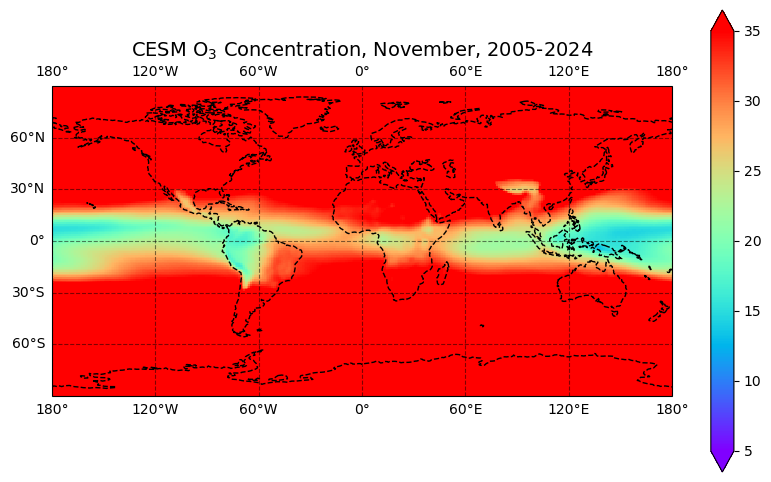

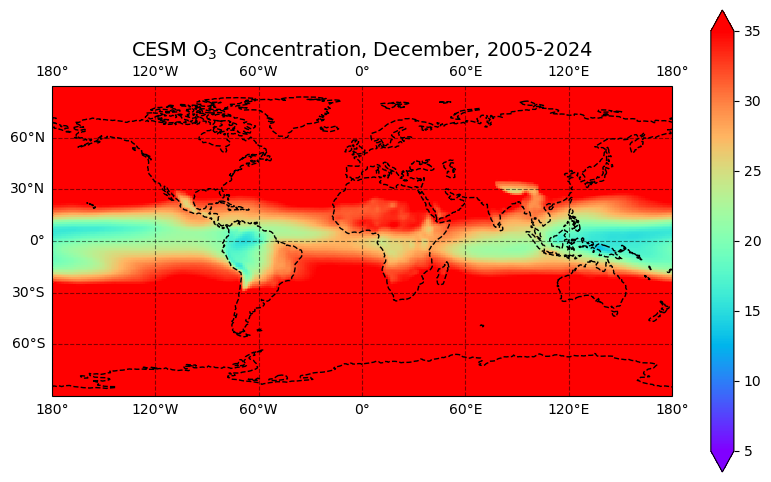

In [22]:
month_list = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

for i in range(12):
    plotting_module.plotting_ozone(cesm_regridded, i, "CESM $\mathregular{O_3}$ Concentration,", month_list, 5, 35, 'rainbow')

In [23]:
difference = cesm_regridded - omi_mls_ds

print(difference.mean(dim={'month','lat','lon'}, skipna=True))

<xarray.DataArray ()> Size: 4B
array(3.8292935, dtype=float32)


In [24]:
image_dir = '/glade/u/home/mvoncyga/SOARS_2025/figures/'

#create_gif(image_dir, "Difference_Plot.gif", duration=1000, "CESM_Diff")

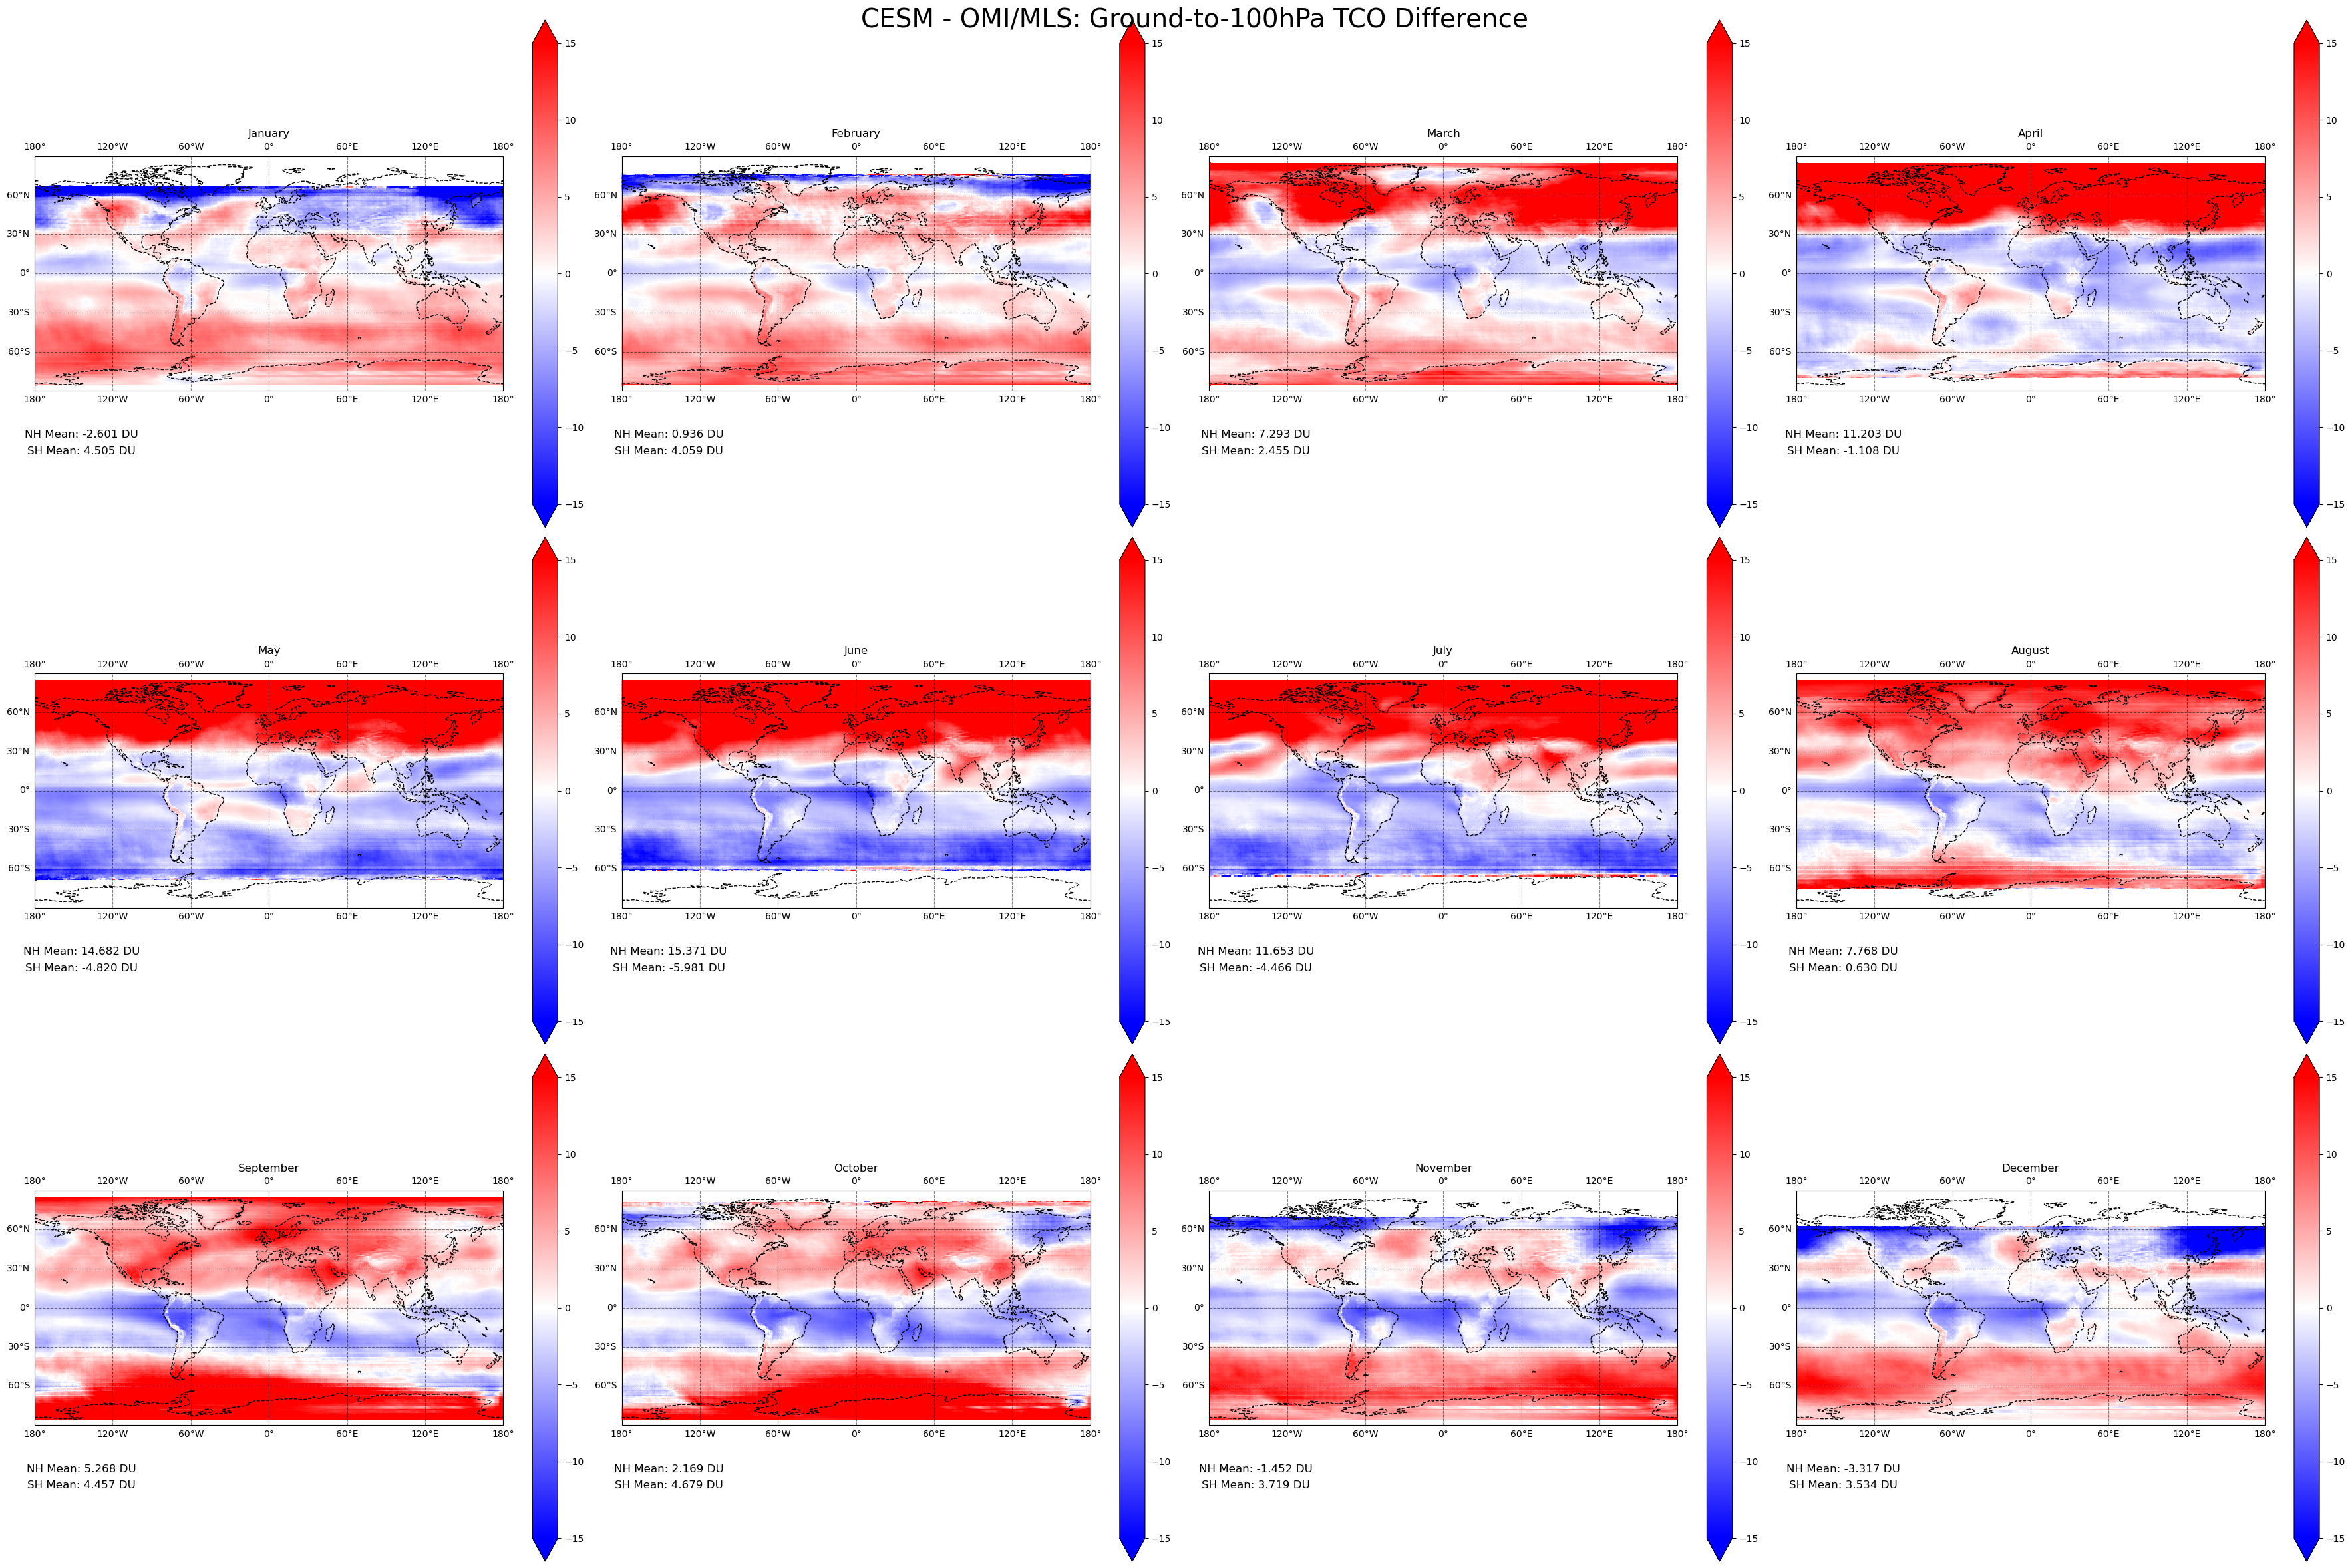

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(36, 24), subplot_kw=dict(projection=ccrs.PlateCarree()))

for i, ax in enumerate(axes.ravel()):
    #ax.spines[axis].set_linewidth(100.5)
    difference[i].plot(ax=ax,transform=ccrs.PlateCarree(central_longitude=0), vmin=-15, vmax=15, extend='both', cmap='bwr')
    ax.set_global()
    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    gl.right_labels = False
    
    # adding textual info
    nh_formatted_mean = f"{difference[i].sel(lat=slice(0,90)).mean(dim={'lat','lon'}, skipna=True).data:.3f}"
    ax.text(0.10, -0.21, 'NH Mean: ' + str(nh_formatted_mean) + ' DU', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12)
    
    sh_formatted_mean = f"{difference[i].sel(lat=slice(-90,0)).mean(dim={'lat','lon'}, skipna=True).data:.3f}"
    ax.text(0.10, -0.28, 'SH Mean: ' + str(sh_formatted_mean) + ' DU', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes, fontsize=12)
    

    ax.add_feature(cfeature.COASTLINE, linestyle='--')
    ax.set_title(f'{month_list[i]}')
    fig.suptitle('CESM - OMI/MLS: Ground-to-100hPa TCO Difference', fontsize=28)
    plt.tight_layout()


plt.savefig("figures/Difference_Climatology_100hPa")
plt.show()